In [1]:
import time
from pynq import Overlay
import numpy as np
from pynq import Xlnk
import struct
from scipy.misc import imread
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def readbinfile(filename,size):
    f = open(filename, "rb")
    z=[]
    for j in range(size):
        data = f.read(4)
        data_float = struct.unpack("f", data)[0]
        z.append(data_float)
    f.close()
    z = np.array(z)
    return z

def RunConv(conv,Kx,Ky,Sx,Sy,mode,relu_en,feature_in,W,bias,feature_out):
    conv.write(0x10,feature_in.shape[2]);
    conv.write(0x18,feature_in.shape[0]);
    conv.write(0x20,feature_in.shape[1]);
    conv.write(0x28,feature_out.shape[2]);
    conv.write(0x30,Kx);
    conv.write(0x38,Ky);
    conv.write(0x40,Sx);
    conv.write(0x48,Sy);
    conv.write(0x50,mode);
    conv.write(0x58,relu_en);
    conv.write(0x60,feature_in.physical_address);
    conv.write(0x68,W.physical_address);
    conv.write(0x70,bias.physical_address);
    conv.write(0x78,feature_out.physical_address);
    conv.write(0, (conv.read(0)&0x80)|0x01 );
    tp=conv.read(0)
    while not ((tp>>1)&0x1):
        tp=conv.read(0);
    #print(tp);

def RunPool(pool,Kx,Ky,mode,feature_in,feature_out):
    pool.write(0x10,feature_in.shape[2]);
    pool.write(0x18,feature_in.shape[0]);
    pool.write(0x20,feature_in.shape[1]);
    pool.write(0x28,Kx);
    pool.write(0x30,Ky);
    pool.write(0x38,mode);
    pool.write(0x40,feature_in.physical_address);
    pool.write(0x48,feature_out.physical_address);
    pool.write(0, (pool.read(0)&0x80)|0x01 );
    while not ((pool.read(0)>>1)&0x1):
        pass;

In [3]:
#Conv1
IN_WIDTH1=28
IN_HEIGHT1=28
IN_CH1=1

KERNEL_WIDTH1=3
KERNEL_HEIGHT1=3
X_STRIDE1=1
Y_STRIDE1=1

RELU_EN1=1
MODE1=1  #0:VALID, 1:SAME
if(MODE1):
    X_PADDING1=int((KERNEL_WIDTH1-1)/2)
    Y_PADDING1=int((KERNEL_HEIGHT1-1)/2)
else:
    X_PADDING1=0
    Y_PADDING1=0

OUT_CH1=32
OUT_WIDTH1=int((IN_WIDTH1+2*X_PADDING1-KERNEL_WIDTH1)/X_STRIDE1+1)
OUT_HEIGHT1=int((IN_HEIGHT1+2*Y_PADDING1-KERNEL_HEIGHT1)/Y_STRIDE1+1)


#Pool1
MODE11=2  #mode: 0:MEAN, 1:MIN, 2:MAX
IN_WIDTH11=OUT_WIDTH1
IN_HEIGHT11=OUT_HEIGHT1
IN_CH11=OUT_CH1

KERNEL_WIDTH11=2
KERNEL_HEIGHT11=2

OUT_CH11=IN_CH11
OUT_WIDTH11=int(IN_WIDTH11/KERNEL_WIDTH11)
OUT_HEIGHT11=int(IN_HEIGHT11/KERNEL_HEIGHT11)

#Conv2
IN_WIDTH2=OUT_WIDTH11
IN_HEIGHT2=OUT_HEIGHT11
IN_CH2=OUT_CH11

KERNEL_WIDTH2=3
KERNEL_HEIGHT2=3
X_STRIDE2=1
Y_STRIDE2=1

RELU_EN2=1
MODE2=1  #0:VALID, 1:SAME
if(MODE2):
    X_PADDING2=int((KERNEL_WIDTH2-1)/2)
    Y_PADDING2=int((KERNEL_HEIGHT2-1)/2)
else:
    X_PADDING2=0
    Y_PADDING2=0

OUT_CH2=64
OUT_WIDTH2=int((IN_WIDTH2+2*X_PADDING2-KERNEL_WIDTH2)/X_STRIDE2+1)
OUT_HEIGHT2=int((IN_HEIGHT2+2*Y_PADDING2-KERNEL_HEIGHT2)/Y_STRIDE2+1)

#Pool2
MODE21=2  #mode: 0:MEAN, 1:MIN, 2:MAX
IN_WIDTH21=OUT_WIDTH2
IN_HEIGHT21=OUT_HEIGHT2
IN_CH21=OUT_CH2

KERNEL_WIDTH21=2
KERNEL_HEIGHT21=2

OUT_CH21=IN_CH21
OUT_WIDTH21=int(IN_WIDTH21/KERNEL_WIDTH21)
OUT_HEIGHT21=int(IN_HEIGHT21/KERNEL_HEIGHT21)


#Conv3
IN_WIDTH3=OUT_WIDTH21
IN_HEIGHT3=OUT_HEIGHT21
IN_CH3=OUT_CH21

KERNEL_WIDTH3=3
KERNEL_HEIGHT3=3
X_STRIDE3=1
Y_STRIDE3=1

RELU_EN3=1
MODE3=1  #0:VALID, 1:SAME
if(MODE3):
    X_PADDING3=int((KERNEL_WIDTH2-1)/2)
    Y_PADDING3=int((KERNEL_HEIGHT2-1)/2)
else:
    X_PADDING3=0
    Y_PADDING3=0

OUT_CH3=64
OUT_WIDTH3=int((IN_WIDTH3+2*X_PADDING3-KERNEL_WIDTH3)/X_STRIDE3+1)
OUT_HEIGHT3=int((IN_HEIGHT3+2*Y_PADDING3-KERNEL_HEIGHT3)/Y_STRIDE3+1)

#Pool3
MODE31=2  #mode: 0:MEAN, 1:MIN, 2:MAX
IN_WIDTH31=OUT_WIDTH3
IN_HEIGHT31=OUT_HEIGHT3
IN_CH31=OUT_CH3

KERNEL_WIDTH31=2
KERNEL_HEIGHT31=2

OUT_CH31=IN_CH31
OUT_WIDTH31=int(IN_WIDTH31/KERNEL_WIDTH31)
OUT_HEIGHT31=int(IN_HEIGHT31/KERNEL_HEIGHT31)

#Fc1
IN_WIDTH4=OUT_WIDTH31
IN_HEIGHT4=OUT_HEIGHT31
IN_CH4=OUT_CH31

KERNEL_WIDTH4=3
KERNEL_HEIGHT4=3
X_STRIDE4=1
Y_STRIDE4=1

RELU_EN4=1
MODE4=0  #0:VALID, 1:SAME
if(MODE4):
    X_PADDING4=int((KERNEL_WIDTH4-1/2))
    Y_PADDING4=int((KERNEL_HEIGHT4-1)/2)
else:
    X_PADDING4=0
    Y_PADDING4=0

OUT_CH4=128
OUT_WIDTH4=int((IN_WIDTH4+2*X_PADDING4-KERNEL_WIDTH4)/X_STRIDE4+1)
OUT_HEIGHT4=int((IN_HEIGHT4+2*Y_PADDING4-KERNEL_HEIGHT4)/Y_STRIDE4+1)

#Fc2
IN_WIDTH5=OUT_WIDTH4
IN_HEIGHT5=OUT_HEIGHT4
IN_CH5=OUT_CH4

KERNEL_WIDTH5=1
KERNEL_HEIGHT5=1
X_STRIDE5=1
Y_STRIDE5=1

RELU_EN5=1
MODE5=0  #0:VALID, 1:SAME
if(MODE5):
    X_PADDING5=int((KERNEL_WIDTH5-1/2))
    Y_PADDING5=int((KERNEL_HEIGHT5-1)/2)
else:
    X_PADDING5=0
    Y_PADDING5=0

OUT_CH5=10
OUT_WIDTH5=int((IN_WIDTH5+2*X_PADDING5-KERNEL_WIDTH5)/X_STRIDE5+1)
OUT_HEIGHT5=int((IN_HEIGHT5+2*Y_PADDING5-KERNEL_HEIGHT5)/Y_STRIDE5+1)

In [4]:
ol=Overlay("ai.bit")
ol.ip_dict
ol.download()
conv=ol.Conv_0
pool=ol.Pool_0
print("Overlay download finish");

Overlay download finish


In [5]:
xlnk=Xlnk();
#input image
image=xlnk.cma_array(shape=(IN_HEIGHT1,IN_WIDTH1,IN_CH1),cacheable=0,dtype=np.float32)

#conv1
W_conv1=xlnk.cma_array(shape=(KERNEL_HEIGHT1,KERNEL_WIDTH1,IN_CH1,OUT_CH1),cacheable=0,dtype=np.float32)
b_conv1=xlnk.cma_array(shape=(OUT_CH1),cacheable=0,dtype=np.float32)
h_conv1=xlnk.cma_array(shape=(OUT_HEIGHT1,OUT_WIDTH1,OUT_CH1),cacheable=0,dtype=np.float32)
h_pool1=xlnk.cma_array(shape=(OUT_HEIGHT11,OUT_WIDTH11,OUT_CH11),cacheable=0,dtype=np.float32)

#conv2
W_conv2=xlnk.cma_array(shape=(KERNEL_HEIGHT2,KERNEL_WIDTH2,IN_CH2,OUT_CH2),cacheable=0,dtype=np.float32)
b_conv2=xlnk.cma_array(shape=(OUT_CH2),cacheable=0,dtype=np.float32)
h_conv2=xlnk.cma_array(shape=(OUT_HEIGHT2,OUT_WIDTH2,OUT_CH2),cacheable=0,dtype=np.float32)
h_pool2=xlnk.cma_array(shape=(OUT_HEIGHT21,OUT_WIDTH21,OUT_CH21),cacheable=0,dtype=np.float32)

#conv3
W_conv3=xlnk.cma_array(shape=(KERNEL_HEIGHT3,KERNEL_WIDTH3,IN_CH3,OUT_CH3),cacheable=0,dtype=np.float32)
b_conv3=xlnk.cma_array(shape=(OUT_CH3),cacheable=0,dtype=np.float32)
h_conv3=xlnk.cma_array(shape=(OUT_HEIGHT3,OUT_WIDTH3,OUT_CH3),cacheable=0,dtype=np.float32)
h_pool3=xlnk.cma_array(shape=(OUT_HEIGHT31,OUT_WIDTH31,OUT_CH31),cacheable=0,dtype=np.float32)

#fc1
W_fc1=xlnk.cma_array(shape=(KERNEL_HEIGHT4, KERNEL_WIDTH4, IN_CH4, OUT_CH4),cacheable=0,dtype=np.float32)
b_fc1=xlnk.cma_array(shape=(OUT_CH4),cacheable=0,dtype=np.float32)
h_fc1=xlnk.cma_array(shape=(OUT_HEIGHT4,OUT_WIDTH4,OUT_CH4),cacheable=0,dtype=np.float32)

#fc2
W_fc2=xlnk.cma_array(shape=(KERNEL_HEIGHT5, KERNEL_WIDTH5, IN_CH5, OUT_CH5),cacheable=0,dtype=np.float32)
b_fc2=xlnk.cma_array(shape=(OUT_CH5),cacheable=0,dtype=np.float32)
h_fc2=xlnk.cma_array(shape=(OUT_HEIGHT5,OUT_WIDTH5,OUT_CH5),cacheable=0,dtype=np.float32)

In [6]:
#Initialize W, bias

w_conv1=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/conv1_0_weight_t.bin",KERNEL_HEIGHT1*KERNEL_WIDTH1*IN_CH1*OUT_CH1)
w_conv1=w_conv1.reshape((KERNEL_HEIGHT1,KERNEL_WIDTH1,IN_CH1,OUT_CH1))
for i in range(KERNEL_HEIGHT1):
    for j in range(KERNEL_WIDTH1):
        for k in range(IN_CH1):
            for l in range(OUT_CH1):
                W_conv1[i][j][k][l]=w_conv1[i][j][k][l]
B_conv1=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/conv1_0_bias_t.bin",OUT_CH1)
for i in range(OUT_CH1):
    b_conv1[i]=B_conv1[i]

w_conv2=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/conv2_0_weight_t.bin",KERNEL_HEIGHT2*KERNEL_WIDTH2*IN_CH2*OUT_CH2)
w_conv2=w_conv2.reshape((KERNEL_HEIGHT2,KERNEL_WIDTH2,IN_CH2,OUT_CH2))
for i in range(KERNEL_HEIGHT2):
    for j in range(KERNEL_WIDTH2):
        for k in range(IN_CH2):
            for l in range(OUT_CH2):
                W_conv2[i][j][k][l]=w_conv2[i][j][k][l]
B_conv2=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/conv2_0_bias_t.bin",OUT_CH2)
for i in range(OUT_CH2):
    b_conv2[i]=B_conv2[i]

w_conv3=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/conv3_0_weight_t.bin",KERNEL_HEIGHT3*KERNEL_WIDTH3*IN_CH3*OUT_CH3)
w_conv3=w_conv3.reshape((KERNEL_HEIGHT3,KERNEL_WIDTH3,IN_CH3,OUT_CH3))
for i in range(KERNEL_HEIGHT3):
    for j in range(KERNEL_WIDTH3):
        for k in range(IN_CH3):
            for l in range(OUT_CH3):
                W_conv3[i][j][k][l]=w_conv3[i][j][k][l]
B_conv3=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/conv3_0_bias_t.bin",OUT_CH3)
for i in range(OUT_CH3):
    b_conv3[i]=B_conv3[i]
    
w_fc1=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/dense1_0_weight_t.bin",KERNEL_HEIGHT4*KERNEL_WIDTH4*IN_CH4*OUT_CH4)
w_fc1=w_fc1.reshape((KERNEL_HEIGHT4,KERNEL_WIDTH4,IN_CH4,OUT_CH4))
for i in range(KERNEL_HEIGHT4):
    for j in range(KERNEL_WIDTH4):
        for k in range(IN_CH4):
            for l in range(OUT_CH4):
                W_fc1[i][j][k][l]=w_fc1[i][j][k][l]
B_fc1=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/dense1_0_bias_t.bin",OUT_CH4)
for i in range(OUT_CH4):
    b_fc1[i]=B_fc1[i]

w_fc2=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/dense2_0_weight_t.bin",KERNEL_HEIGHT5*KERNEL_WIDTH5*IN_CH5*OUT_CH5)
w_fc2=w_fc2.reshape((KERNEL_HEIGHT5,KERNEL_WIDTH5,IN_CH5,OUT_CH5))
for i in range(KERNEL_HEIGHT5):
    for j in range(KERNEL_WIDTH5):
        for k in range(IN_CH5):
            for l in range(OUT_CH5):
                W_fc2[i][j][k][l]=w_fc2[i][j][k][l]
B_fc2=readbinfile("/home/xilinx/jupyter_notebooks/mnist_3C_2F/data/dense2_0_bias_t.bin",OUT_CH5)
for i in range(OUT_CH5):
    b_fc2[i]=B_fc2[i]

print("Finish initial")

Finish initial


Read image
Finish reading image
Hardware run time=4.9986488819122314 s
Hardware run finish
The number you write is 0


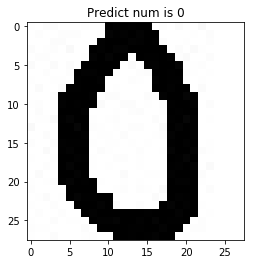

Read image
Finish reading image
Hardware run time=5.003968715667725 s
Hardware run finish
The number you write is 1


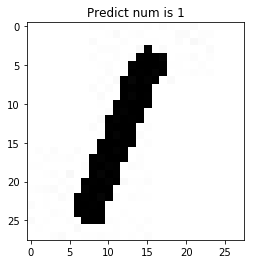

Read image
Finish reading image
Hardware run time=5.004502058029175 s
Hardware run finish
The number you write is 2


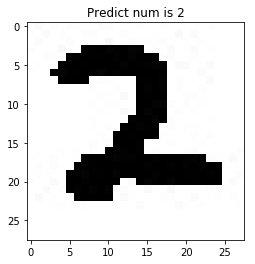

Read image
Finish reading image
Hardware run time=5.003693342208862 s
Hardware run finish
The number you write is 3


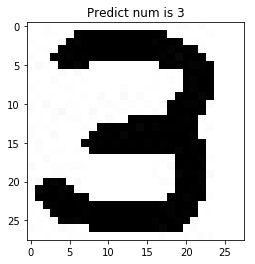

Read image
Finish reading image
Hardware run time=5.006304740905762 s
Hardware run finish
The number you write is 4


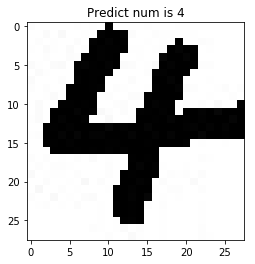

Read image
Finish reading image
Hardware run time=4.998209238052368 s
Hardware run finish
The number you write is 5


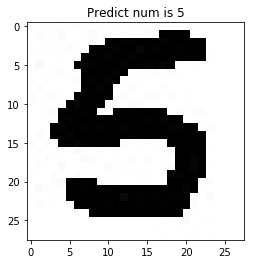

Read image
Finish reading image
Hardware run time=4.997265100479126 s
Hardware run finish
The number you write is 6


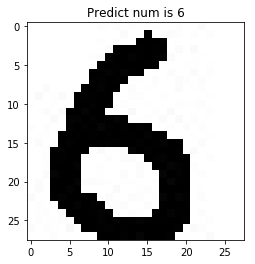

Read image
Finish reading image
Hardware run time=5.00068998336792 s
Hardware run finish
The number you write is 7


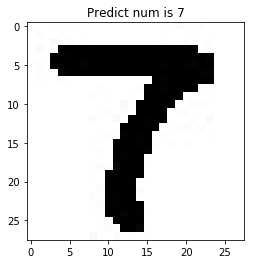

Read image
Finish reading image
Hardware run time=5.0048441886901855 s
Hardware run finish
The number you write is 8


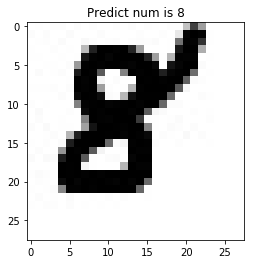

Read image
Finish reading image
Hardware run time=5.000162839889526 s
Hardware run finish
The number you write is 9


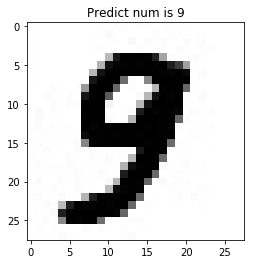

In [7]:
for num in range(10): #0~9
    start=time.time()
    test_pic_path = "/home/xilinx/jupyter_notebooks/mnist_3C_2F/test_pic/" + str(num)+".jpg"
    image1 = cv2.imread(test_pic_path,cv2.IMREAD_GRAYSCALE).astype(np.float32)
    print("Read image")
    #image1=image1.reshape((IN_HEIGHT1,IN_WIDTH1,IN_CH1))
    for i in range(IN_HEIGHT1):
        for j in range(IN_WIDTH1):
            for k in range(IN_CH1):
                image[i][j][k]=((255-image1[i][j])/255-0.1307)/0.3081
#                 print("\r\n"+str(image[i][j][k]))
    print("Finish reading image")
    #conv1
    RunConv(conv,KERNEL_WIDTH1,KERNEL_HEIGHT1,X_STRIDE1,Y_STRIDE1,MODE1,RELU_EN1,image,W_conv1,b_conv1,h_conv1)
    RunPool(pool, KERNEL_WIDTH11, KERNEL_HEIGHT11, MODE11, h_conv1, h_pool1)
    # conv2
    RunConv(conv, KERNEL_WIDTH2, KERNEL_HEIGHT2, X_STRIDE2, Y_STRIDE2, MODE2, RELU_EN2, h_pool1, W_conv2, b_conv2,
            h_conv2)
    RunPool(pool, KERNEL_WIDTH21, KERNEL_HEIGHT21, MODE21, h_conv2, h_pool2)
    # conv3
    RunConv(conv, KERNEL_WIDTH3, KERNEL_HEIGHT3, X_STRIDE3, Y_STRIDE3, MODE3, RELU_EN3, h_pool2, W_conv3, b_conv3,
            h_conv3)
    RunPool(pool, KERNEL_WIDTH31, KERNEL_HEIGHT31, MODE31, h_conv3, h_pool3)
    # fc1
    RunConv(conv, KERNEL_WIDTH4, KERNEL_HEIGHT4, X_STRIDE4, Y_STRIDE4, MODE4, RELU_EN4, h_pool3, W_fc1, b_fc1,
            h_fc1)
    # fc2
    RunConv(conv, KERNEL_WIDTH5, KERNEL_HEIGHT5, X_STRIDE5, Y_STRIDE5, MODE5, RELU_EN5, h_fc1, W_fc2, b_fc2,
            h_fc2)
    
    end=time.time()
    print("Hardware run time=%s s"%(end-start))
    print("Hardware run finish")
    MAX = h_fc2[0][0][0]
    result=0
#     for i in range(0,OUT_CH5):
# #         print(str(h_fc2[0][0][i])+",")
    
    for i in range(1,OUT_CH5):
        if(h_fc2[0][0][i]>MAX):
            MAX=h_fc2[0][0][i]
            result=i
    print("The number you write is "+str(result))

    img=plt.imread(test_pic_path)  #读取文件图片
    #print(img.shape)
    title = "Predict num is "+str(result)
    plt.title(title)# 设置字体大小与格式
    plt.imshow(img)
    plt.show()
